In [1]:

from himalaya.backend import set_backend

from simulation import generate_dataset

set_backend("cupy", on_error="warn")

# disable warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
feature_space_dimensions = [
    100,  # shared
    100,  # unique 0
    100,  # unique 1
]
scalars = [
    1 / 3,
    1 / 3,
    1 / 3,
]
n_targets = 10
n_samples_train = 1000
n_samples_test = 100
noise = 0.0

cv = 10

In [3]:
(Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, scalars, n_targets, n_samples_train,
                                                        n_samples_test, noise)

# Variance Partitioning

In [4]:
def errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars, n_targets,
             n_samples_train, n_samples_test, noise):
    import matplotlib.pyplot as plt
    import numpy as np

    bars = [score_0.mean(), score_1.mean(), joint_score.mean(), shared.mean(), x0_unique.mean(), x1_unique.mean()]

    yerr = [
        np.sqrt(score_0.var()) / np.sqrt(n_samples_train),
        np.sqrt(score_1.var()) / np.sqrt(n_samples_train),
        np.sqrt(joint_score.var()) / np.sqrt(n_samples_train),
        np.sqrt(shared.var()) / np.sqrt(n_samples_train),
        np.sqrt(x0_unique.var()) / np.sqrt(n_samples_train),
        np.sqrt(x1_unique.var()) / np.sqrt(n_samples_train),
    ]
    bar_names = [r"$X_0$ only", r"$X_1$ only", r"$X_0 \cup X_1$", r"$X_0 \cap X_1$", r"$X_0 \setminus X_1$",
                 r"$X_1 \setminus X_0$"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
    plt.bar(range(len(bars)), bars, color=colors, yerr=yerr, capsize=5, ecolor="black")
    # plt.errorbar(range(len(bars)), bars, yerr=yerr, fmt='')

    plt.xticks(range(len(bars)), labels=bar_names)

    # plot horizontal line at 1/3 and 2/3
    plt.axhline(y=scalars[0], linestyle='--', label=r"$a_S$")
    plt.axhline(y=scalars[1], linestyle='--', label=r"$a_{U_0}$", color=colors[3])
    plt.axhline(y=scalars[2], linestyle='--', label=r"$a_{U_1}$", color=colors[4])
    plt.axhline(y=scalars[0] + scalars[1], linestyle='--', label=r"$a_S + a_{U_0}$", color=colors[0])
    plt.axhline(y=scalars[0] + scalars[2], linestyle='--', label=r"$a_S + a_{U_1}$", color=colors[1])
    plt.legend()

    plt.ylim(0, 1)
    plt.ylabel("Average Variance Explained")
    plt.xlabel("Feature space")

    plt.suptitle("Variance partitioning")
    plt.title(
        fr"{n_targets} targets, $a_S$: {scalars[0]:.2f}, $|S|$: {feature_space_dimensions[0]}, $a_U0$: {scalars[1]:.2f}, $|U_0|$: {feature_space_dimensions[1]}, $a_U1$: {scalars[2]:.2f}, $|U_1|$: {feature_space_dimensions[2]}, $a_E$: {noise}")
    plt.tight_layout()
    plt.show()

In [5]:
from variance_partitioning import variance_partitioning

In [6]:
(score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test, Y_train,
                                                                                      Y_test, cv=cv)

I assume that x0_unique and x1_unique and shared should be the same, since they all contribute equally to the target.

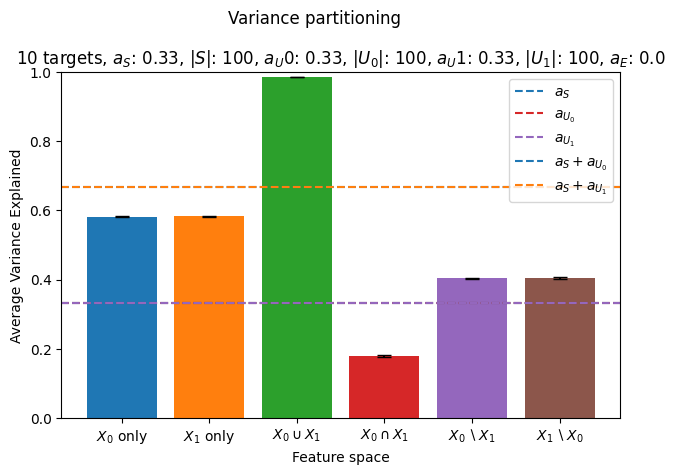

In [7]:
errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars, n_targets,
         n_samples_train, n_samples_test, noise)

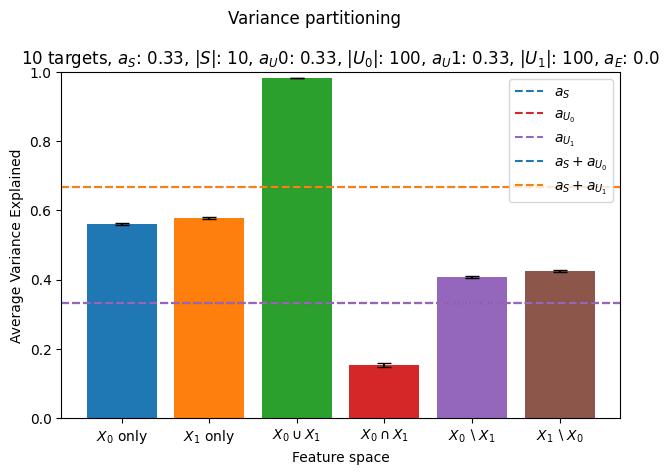

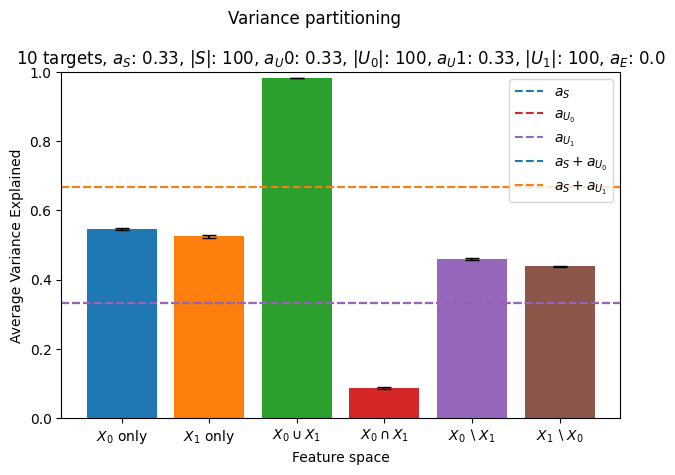

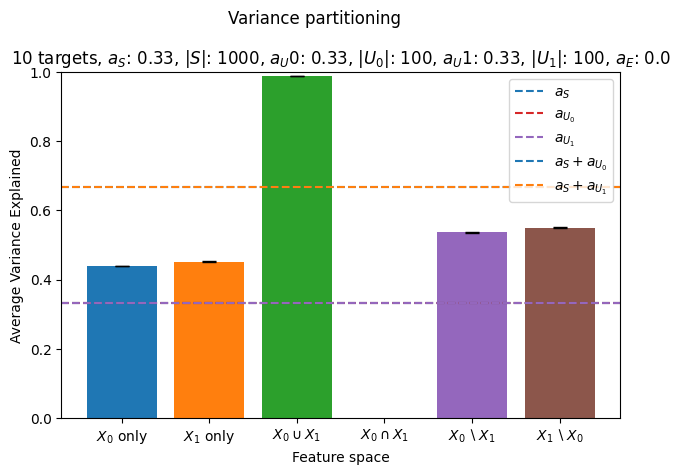

In [8]:
for shared_dimension in [10, 100, 1000]:
    dimensions = feature_space_dimensions.copy()
    dimensions[0] = shared_dimension

    n_samples_train = 2 * sum(dimensions)

    (Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(dimensions, scalars, n_targets, n_samples_train,
                                                            n_samples_test, noise)
    (score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test, Y_train,
                                                                                          Y_test, cv=cv)
    errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, dimensions, scalars, n_targets,
             n_samples_train, n_samples_test, noise)


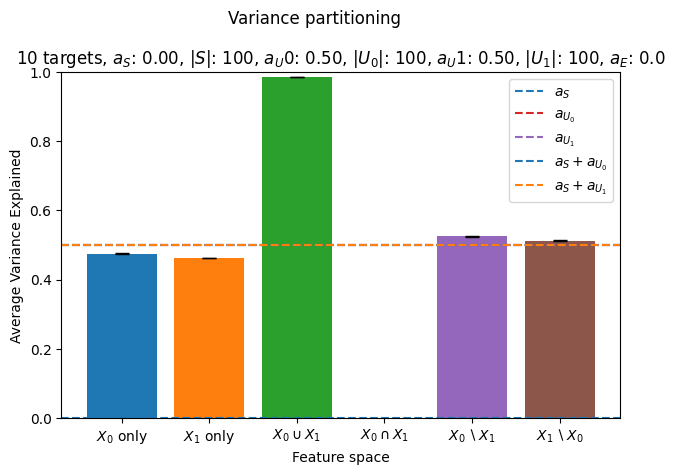

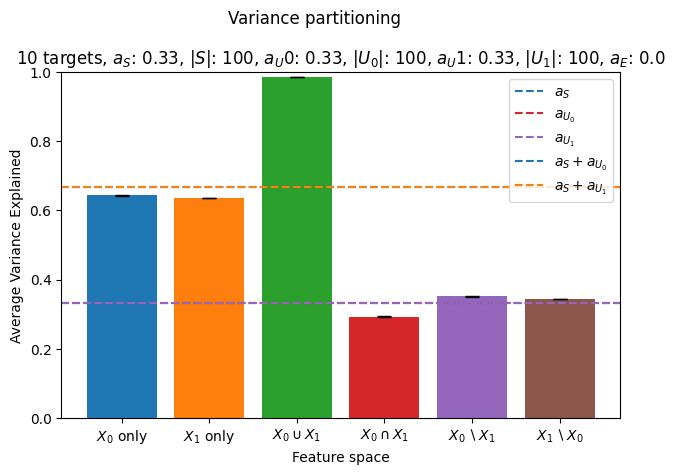

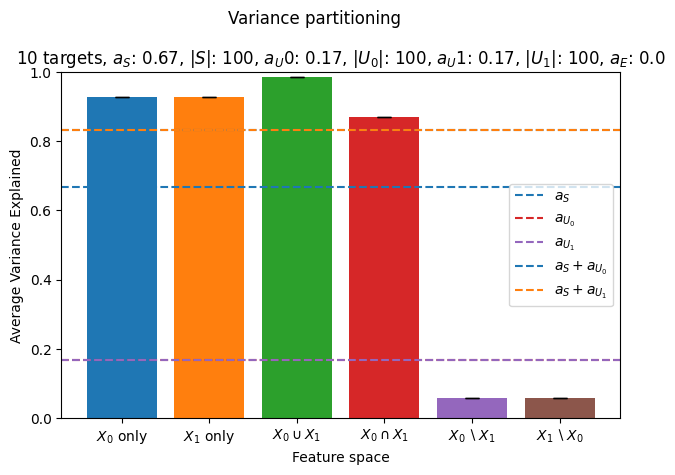

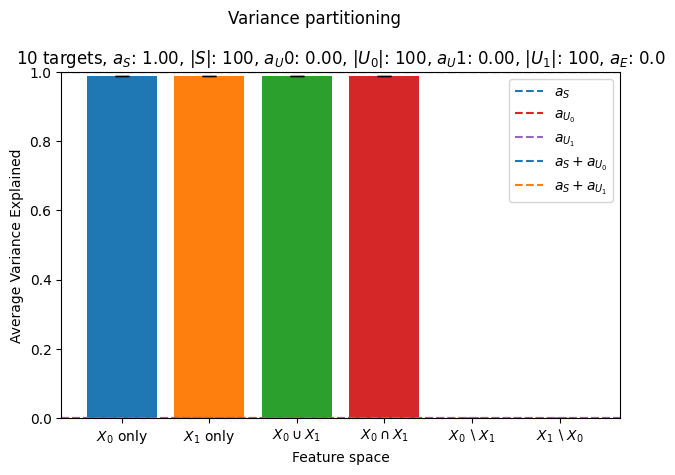

In [9]:
for shared_scalar in [0.0, 1 / 3, 2 / 3, 1.0]:
    _scalars = [shared_scalar, (1 - shared_scalar) / 2, (1 - shared_scalar) / 2]
    (Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, _scalars, n_targets,
                                                            n_samples_train, n_samples_test, noise)
    (score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test, Y_train,
                                                                                          Y_test, cv=cv)
    errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, _scalars, n_targets,
             n_samples_train, n_samples_test, noise)

# Residual Method

In [10]:
from residual import residual_method

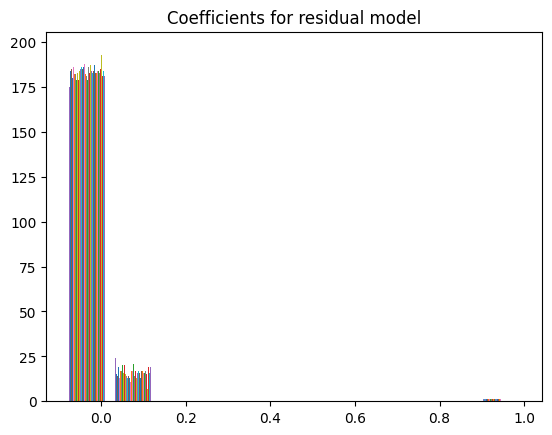

In [11]:
residual, feature, full = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=True, return_full_variance=True,
                                          cv=cv)

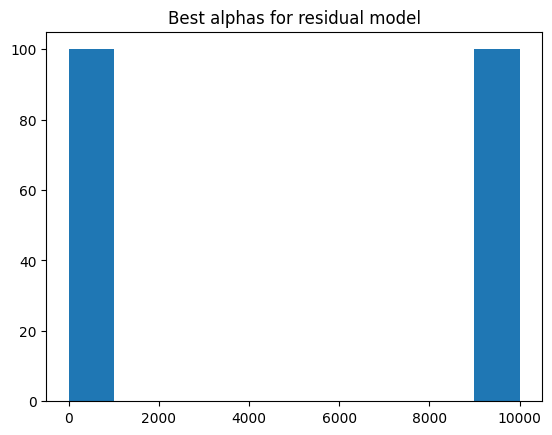

In [12]:
residual_ridge, feature_ridge, _ = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=False, cv=cv)

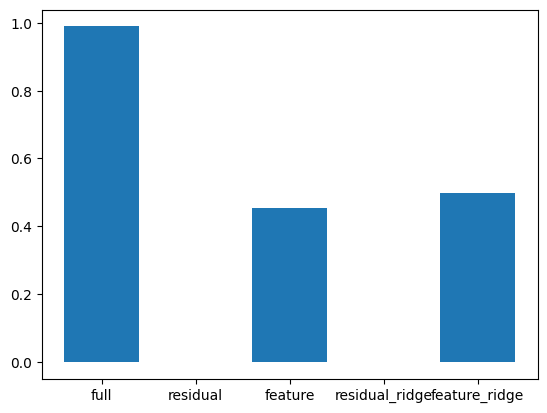

In [13]:
import matplotlib.pyplot as plt

bars = [full.mean(),
        residual.mean(),
        feature, residual_ridge.mean(), feature_ridge.mean()]
bar_names = ["full",
             "residual",
             "feature", "residual_ridge", "feature_ridge"]
plt.bar(range(len(bars)), bars)
plt.xticks(range(len(bars)), labels=bar_names)
plt.show()